<a href="https://colab.research.google.com/github/MattiaGatto/prediction-superenalotto/blob/main/prediction_number_of_superenalotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che calcola la miglior combinazione in uscita alla prossima estrazione del SuperEnalotto basandosi sull estrazioni passate

---
# Librerie necessarie all'utilizzo

In [ ]:
!pip install --upgrade pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from datetime import date
from bs4 import BeautifulSoup
plt.style.use('fivethirtyeight')
from google.colab import drive
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load 
from pathlib import Path
from sklearn.metrics import mean_squared_error
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


## Riceverò i dati attraverso il seguente url.



In [ ]:
date.today().year

2022

In [ ]:
OGGI=date.today()
URL = "https://www.superenalotto.net/estrazioni/"+str(OGGI.year)
resp = requests.get(URL)
print(resp.status_code)

200


---
## Analisi di una pagina web per fare scraping
Analizziamo velocemente, usando l’ispezione di Chrome, la pagina Web per individuare le informazioni che ci interessano: digitiamo allora nel campo di ricerca del browser https://www.superenalotto.net/estrazioni/2022 e premiamo il tasto F12: dovremmo vedere una cosa simile a quella di seguito:

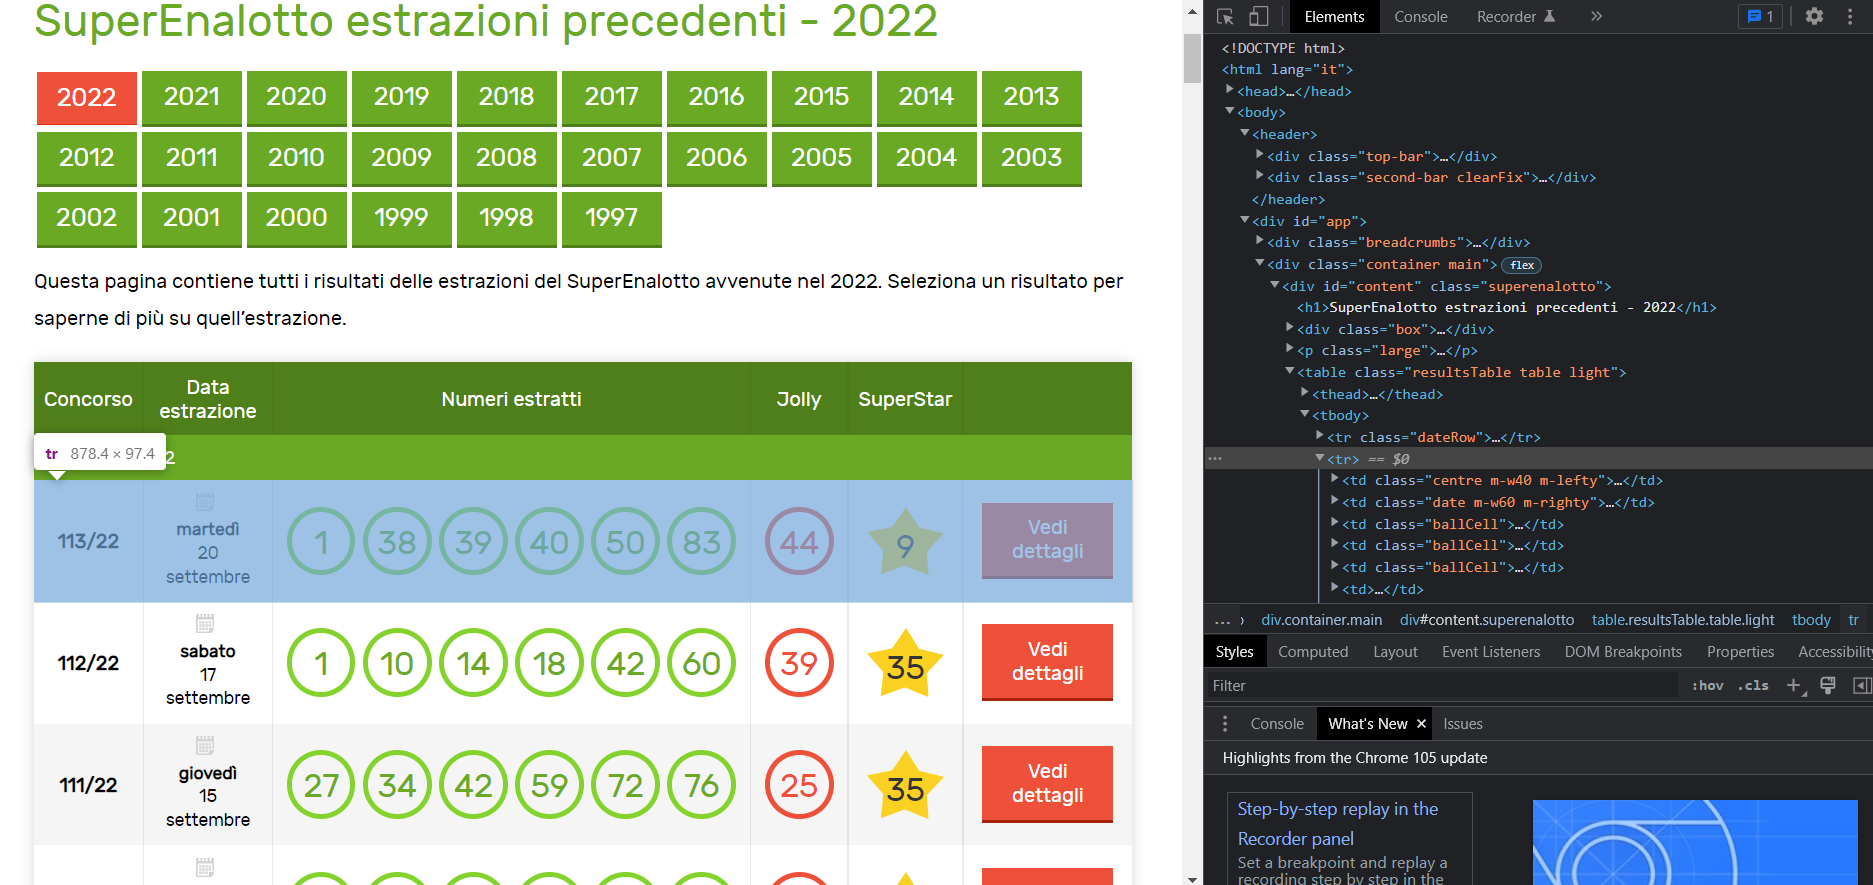

### Il prossimo passo è quello di  muoverci all’interno dei contenuti della pagina al fine di individuare in che punto del documento HTML si trovano le informazioni che ci interessano.

### Lo studio della struttura mostra come essa, a un certo punto, diventi ripetitiva: un tag 'tr' delimita la sezione delle dell'estrazione che contengono i dati che vogliamo acquisire

In [ ]:
def scramping(paragrafo):
  p1=str(paragrafo).split(" ")
  p_new=[]
  for x in p1 :
    if x.strip()!='' and x.strip()!="," and x.strip()!="Vedi" and x.strip()!="dettagli" :
      p_new.append(x.strip())
  # print(p_new)
  
  anno=p_new[1]
  p_p=p_new[2:]
  ann=[]
  settimana=[]
  giorno_della_sett=[]
  giorno_del_mese=[]
  mese=[]
  pallina1=[]
  pallina2=[]
  pallina3=[]
  pallina4=[]
  pallina5=[]
  pallina6=[]
  pallina_jolly=[]
  pallina_superstar=[]
  
  mesi_=["gennaio","febbraio","marzo","aprile","maggio","giugno","luglio","agosto","settembre","ottobre","novembre","dicembre"]
  assenza_jolly=False
  i=0
  x=11
  while i<len(p_p):
    
    if p_p[i] in mesi_:
      i+=2
    y=p_p[i].split("/")
    
    s=int(y[0])
    gs=str(y[1])[2:]
    ann.append(anno)
    settimana.append(s)
    giorno_della_sett.append(gs)
    giorno_del_mese.append(p_p[i+1])
    mese.append(p_p[i+2])
    pallina1.append(p_p[i+3])
    pallina2.append(p_p[i+4])
    pallina3.append(p_p[i+5])
    pallina4.append(p_p[i+6])
    pallina5.append(p_p[i+7])
    pallina6.append(p_p[i+8])
    pallina_jolly.append(p_p[i+9])
    if s==36 and int(anno)==2006:
      assenza_jolly=True
    if int(anno)<2006:
      assenza_jolly=True

    if assenza_jolly==False:
      pallina_superstar.append(p_p[i+10])
      i+=x
    if assenza_jolly==True:
      pallina_superstar.append(None)
      i+=(x-1)
  dataset={"anno":ann,"settimana":settimana,"giorno_della_sett":giorno_della_sett,"giorno_del_mese":giorno_del_mese,"mese":mese,"pallina1":pallina1,"pallina2":pallina2,"pallina3":pallina3,"pallina4":pallina4,"pallina5":pallina5,"pallina6":pallina6,"pallina_jolly":pallina_jolly,"pallina_superstar":pallina_superstar}
  df=pd.DataFrame(dataset)
 
  return df



In [ ]:
def create_dataset():
  dataset={"anno":[],"settimana":[],"giorno_della_sett":[],"giorno_del_mese":[],"mese":[],"pallina1":[],"pallina2":[],"pallina3":[],"pallina4":[],"pallina5":[],"pallina6":[],"pallina_jolly":[],"pallina_superstar":[]}
  years=pd.DataFrame(dataset)
  for i in range (2022-1996):
    URL = "https://www.superenalotto.net/estrazioni/"+str(OGGI.year-i)
    resp = requests.get(URL)
    # print(resp.status_code)

    # creazione di un oggetto "soup"
    data = BeautifulSoup(resp.content)
    # print(data)

    paragrafo = data.find('tbody')
    
    p = paragrafo.text

    years=years.append(scramping(p))
    print(OGGI.year-i)
  return years
years=create_dataset()

2022
2021
2020
2019
2018
2017
2016
2015
2014
2013
2012
2011
2010
2009
2008
2007
2006
2005
2004
2003
2002
2001
2000
1999
1998
1997


In [ ]:
years=years.reset_index(drop=True)
years

,anno,settimana,giorno_della_sett,giorno_del_mese,mese,pallina1,pallina2,pallina3,pallina4,pallina5,pallina6,pallina_jolly,pallina_superstar
0,2022,118.0,sabato,1,ottobre,3,11,14,26,67,82,75,59
1,2022,117.0,giovedì,29,settembre,6,35,37,46,59,86,84,38
2,2022,116.0,martedì,27,settembre,5,22,42,49,62,63,80,36
3,2022,115.0,sabato,24,settembre,19,26,35,44,49,65,24,32
4,2022,114.0,giovedì,22,settembre,15,30,42,65,75,81,72,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3477,1997,91.0,mercoledì,17,dicembre,10,65,77,80,81,86,89,None
3478,1997,90.0,sabato,13,dicembre,5,22,34,61,62,77,58,None
3479,1997,89.0,mercoledì,10,dicembre,1,2,14,23,78,88,40,None
3480,1997,88.0,sabato,6,dicembre,2,4,25,29,30,52,24,None


## Effettuiamo un controllo per vedere se sono state estratte combinazioni simili fino ad oggi


In [ ]:
combinazioni=years.loc[:,['pallina1','pallina2','pallina3','pallina4','pallina5','pallina6']]
riaccaduti6=[]
estrazioni=np.array(combinazioni)
analizzati=0
for x in estrazioni:
  for y in (estrazioni[analizzati+1:]):
    c = 0
    for i in range(len(x)):
      for j in range(len(y)):
        if x[i] == y[j]:
          c += 1
    if c==6:
      print("OK 6")
      riaccaduti6.append(x)
  analizzati+=1

if len(riaccaduti6)==0:
  print("Non sono mai uscite combinazioni uguali")
else:
  print(riaccaduti)

Non sono mai uscite combinazioni uguali


In [ ]:
lista_numeri=np.arange(1,91)
contatore=(np.arange(0, 9, 0.1, dtype=int))
for x in estrazioni:
  for y in x:
    contatore[int(y)-1]+=1
contatore

array([250, 211, 221, 218, 210, 257, 214, 231, 215, 219, 233, 226, 213,
       223, 238, 232, 239, 200, 250, 225, 235, 231, 201, 215, 238, 225,
       216, 215, 218, 216, 219, 245, 232, 222, 235, 207, 240, 244, 242,
       230, 229, 227, 237, 218, 250, 216, 240, 240, 258, 202, 247, 245,
       205, 233, 259, 242, 224, 214, 215, 200, 233, 246, 239, 213, 252,
       250, 223, 248, 219, 220, 230, 235, 218, 236, 247, 231, 266, 230,
       254, 247, 255, 253, 255, 231, 265, 261, 248, 249, 232, 254])

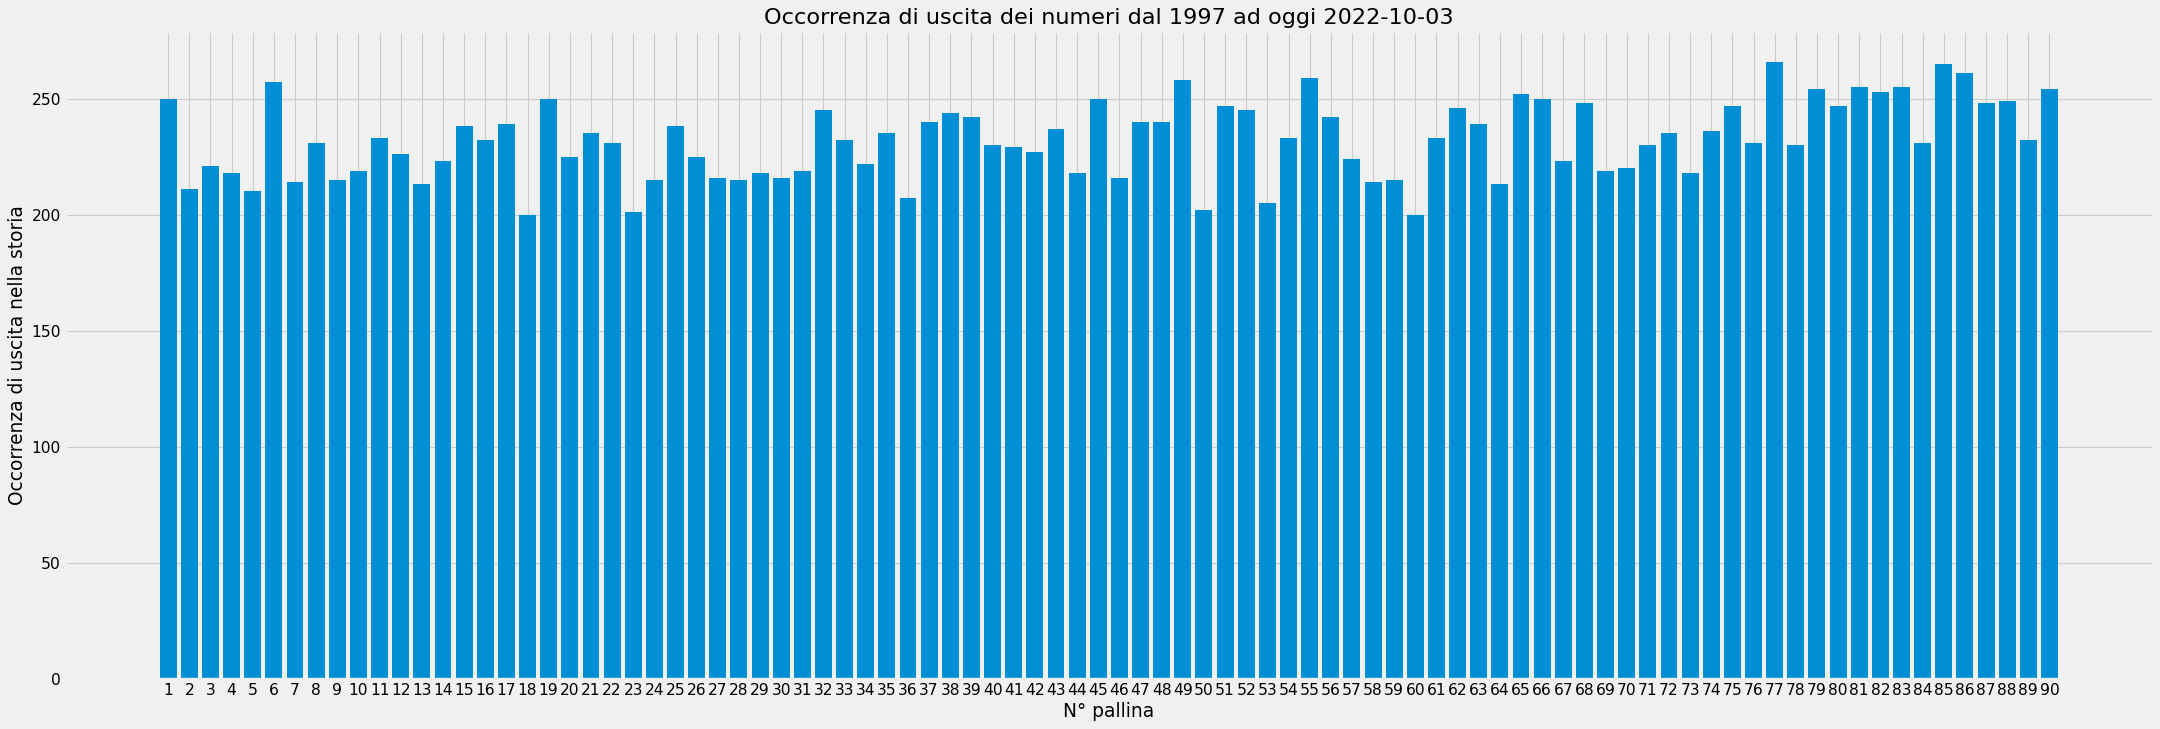

In [ ]:
plt.figure(figsize=(30, 10), dpi=80)
plt.bar(lista_numeri,contatore)
plt.xticks(lista_numeri)
plt.ylabel("Occorrenza di uscita nella storia")
plt.xlabel("N° pallina")
plt.title("Occorrenza di uscita dei numeri dal 1997 ad oggi "+str(OGGI))
plt.show()

In [ ]:
import operator
stats=dict(zip(lista_numeri,contatore))
max_key = max(stats.items(), key=operator.itemgetter(1))[0]
min_key = min(stats.items(), key=operator.itemgetter(1))[0]
print("La pallina che è uscita più volte è:",max_key,"per un totale di",max(stats.values()))
print("La pallina che è uscita meno volte è:",min_key,"per un totale di",min(stats.values()))

La pallina che è uscita più volte è: 77 per un totale di 266
La pallina che è uscita meno volte è: 18 per un totale di 200


---
# DATA PREPARATION

In [ ]:
years=years.drop(['giorno_della_sett', 'mese'], axis=1)

In [ ]:
data = years
#Convertiamolo in un numpy array
dataset = np.array(data.fillna(0),dtype=int)#data.values
training_data_len = math.ceil( len(dataset) *.8) # 80% dei dati

Verrà creato un dataset di addestramento che contenga i valori delle previsioni da oggi a 30 estrazioni precedenti con Valore di previsione nell'y_train pari all'estrazione successiva.

Inoltre verranno effettuati 8 modelli di previsione ciascuno per ogni pallina in uscita.

In [ ]:
#Crea il set di dati per l'addestramento in scala
train_data = dataset[0:training_data_len  , : ]

#Intervallo di previsione
Z=1 

#Dividi i dati nel x_train e  y_train
x_train=[]
y_train = []
for i in range(Z,len(train_data)):
  x_train.append(train_data[i-Z:i])
  y_train.append(train_data[i,3:11])

# Converti x_train e y_train in array
x_train, y_train = np.array(x_train), np.array(y_train)
print("x train shape :",x_train.shape,"\ny train shape :",y_train.shape)

x train shape : (2785, 1, 11) 
y train shape : (2785, 8)


In [ ]:
Giornate_estrazioni_precedenti=30

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[2]))
d=pd.DataFrame(x_train)
d

,0,1,2,3,4,5,6,7,8,9,10
0,2022,118,1,3,11,14,26,67,82,75,59
1,2022,117,29,6,35,37,46,59,86,84,38
2,2022,116,27,5,22,42,49,62,63,80,36
3,2022,115,24,19,26,35,44,49,65,24,32
4,2022,114,22,15,30,42,65,75,81,72,85
...,...,...,...,...,...,...,...,...,...,...,...
2780,2004,61,31,17,29,63,66,70,89,82,0
2781,2004,60,28,2,13,22,53,60,85,16,0
2782,2004,59,24,5,17,18,27,33,47,80,0
2783,2004,58,21,8,13,31,42,58,88,46,0


In [ ]:
i=1
j=0
x=np.array(list([0]*i)+list(d.iloc[: , :][3+j*i])[:len(d.iloc[: , :][3])-i],dtype=int)
len(x)

2785

In [ ]:
df_col_reversed = d.loc[::-1, :].reset_index(drop=True) # reverse row order
df_col_reversed

,0,1,2,3,4,5,6,7,8,9,10
0,2004,57,17,29,53,54,72,76,90,20,0
1,2004,58,21,8,13,31,42,58,88,46,0
2,2004,59,24,5,17,18,27,33,47,80,0
3,2004,60,28,2,13,22,53,60,85,16,0
4,2004,61,31,17,29,63,66,70,89,82,0
...,...,...,...,...,...,...,...,...,...,...,...
2780,2022,114,22,15,30,42,65,75,81,72,85
2781,2022,115,24,19,26,35,44,49,65,24,32
2782,2022,116,27,5,22,42,49,62,63,80,36
2783,2022,117,29,6,35,37,46,59,86,84,38


In [ ]:
def train_set_df(df_col_reversed,drop_list,c):
  df_col_reversed_new=df_col_reversed.drop(drop_list,axis=1)
  df_col_reversed_new=df_col_reversed_new.rename(columns={c:3})
  dataset_=df_col_reversed_new
  ind=0
  for i in range (1,1+Giornate_estrazioni_precedenti):
    zeri=list([0])
    prec=list(dataset_.iloc[:len(dataset_)-1 , :][3+i-1])
    
    add_list=np.array( zeri + prec , dtype=int)

    dataset_[3+i] = add_list
    ind+=1
  d=dataset_.iloc[Giornate_estrazioni_precedenti: , :]
  df = d.fillna(0)
  df=np.array(df,dtype=int)
  x_train=np.array(df)
  x_train=x_train[:len(x_train)-2]
  return x_train

dataset_1=train_set_df(df_col_reversed,[4,5,6,7,8,9,10],3)
dataset_2=train_set_df(df_col_reversed,[3,5,6,7,8,9,10],4)
dataset_3=train_set_df(df_col_reversed,[3,4,6,7,8,9,10],5)
dataset_4=train_set_df(df_col_reversed,[3,4,5,7,8,9,10],6)
dataset_5=train_set_df(df_col_reversed,[3,4,5,6,8,9,10],7)
dataset_6=train_set_df(df_col_reversed,[3,4,5,6,7,9,10],8)
dataset_jolly=train_set_df(df_col_reversed,[3,4,5,6,7,8,10],9)
dataset_superstar=train_set_df(df_col_reversed,[3,4,5,6,7,8,9],10)

In [ ]:
def train_y(c):
  y=[]
  for i in y_train_:
    y.append(i[c])
  return np.array(y,dtype=int)

y_train_= y_train[::-1, :] # reverse row order
y_train_=y_train_[Giornate_estrazioni_precedenti+2:]
y_train_=np.array(pd.DataFrame(y_train_).fillna(0),dtype=int)
y_train_

y_train_1=train_y(0)
y_train_2=train_y(1)
y_train_3=train_y(2)
y_train_4=train_y(3)
y_train_5=train_y(4)
y_train_6=train_y(5)
y_train_jolly=train_y(6)
y_train_superstar=train_y(7)

---
# MODEL TRAINING

In [ ]:
#caricamento 
def load_model(model_path, model):
    model=load(model_path)
    return model

#salvataggio
def save_model(model,model_path):
    dump(model,model_path)
    return model
    
def verifica_esistenza_modello(file_name):
    esiste=False
    try:
        my_file = Path(file_name)
        if my_file.is_file():
          esiste=True
    except IOError:
        print("File not accessible")
    print("Il modello addestrato esiste?",esiste)
    return esiste

## Rimodellare i dati in modo tridimensionale nella forma :

1.   Numero di campioni 
2.   Numero di fasi temporali da prendere in considerazione
3.   numero di caratteristiche

Il modello LSTM si aspetta un set di dati tridimensionale.

In [ ]:
# Reshape i dati nella forma accettata da LSTM
dataset_1 = np.reshape(dataset_1, (dataset_1.shape[0],dataset_1.shape[1],1))
print("1 train shape :",dataset_1.shape)

dataset_2 = np.reshape(dataset_2, (dataset_2.shape[0],dataset_2.shape[1],1))
print("2 train shape :",dataset_2.shape)

dataset_3 = np.reshape(dataset_3, (dataset_3.shape[0],dataset_3.shape[1],1))
print("3 train shape :",dataset_3.shape)

dataset_4 = np.reshape(dataset_4, (dataset_4.shape[0],dataset_4.shape[1],1))
print("4 train shape :",dataset_4.shape)

dataset_5 = np.reshape(dataset_5, (dataset_5.shape[0],dataset_5.shape[1],1))
print("5 train shape :",dataset_5.shape)

dataset_6 = np.reshape(dataset_6, (dataset_6.shape[0],dataset_6.shape[1],1))
print("6 train shape :",dataset_6.shape)

dataset_jolly = np.reshape(dataset_jolly, (dataset_jolly.shape[0],dataset_jolly.shape[1],1))
print("jolly train shape :",dataset_jolly.shape)

dataset_superstar = np.reshape(dataset_superstar, (dataset_superstar.shape[0],dataset_superstar.shape[1],1))
print("superstar train shape :",dataset_superstar.shape)

1 train shape : (2753, 34, 1)
2 train shape : (2753, 34, 1)
3 train shape : (2753, 34, 1)
4 train shape : (2753, 34, 1)
5 train shape : (2753, 34, 1)
6 train shape : (2753, 34, 1)
jolly train shape : (2753, 34, 1)
superstar train shape : (2753, 34, 1)


## Costruisci il modello LSTM per avere :
1. Due strati LSTM con rispettivamente 34 e 16 neuroni;
2. Uno strato denso di 1 neurone in output, ai fini della predizione;

Compilare il modello utilizzando la funzione di perdita dell'errore quadratico medio (MSE) e l'ottimizzatore adam.

In [ ]:
#Costruiamo il LSTM network model
def LSTM_network_model():
  model = Sequential()
  model.add(LSTM(units=34, return_sequences=True,input_shape=(dataset_1.shape[1],1)))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dense(units=1))
  # model.add(Dense(units=1))
  return model



Addestra il modello utilizzando il dataset di addestramento. La dimensione del batch è il numero totale di esempi di addestramento presenti in un singolo batch ed epoch è il numero di iterazioni in cui un intero dataset viene passato avanti e indietro attraverso la rete neurale.


Verifica esistenza modello nella cartella del drive google collegato, se non vi sono vrngono creati su 10 epoche di addestramento

In [ ]:
EPOCHS=10
path_name_1='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallina1_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_1)
exist_model_1=verifica_esistenza_modello(path_name_1)


path_name_2='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallina2_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_2)
exist_model_2=verifica_esistenza_modello(path_name_2)


path_name_3='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallina3_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_3)
exist_model_3=verifica_esistenza_modello(path_name_3)


path_name_4='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallina4_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_4)
exist_model_4=verifica_esistenza_modello(path_name_4)


path_name_5='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallina5_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_5)
exist_model_5=verifica_esistenza_modello(path_name_5)


path_name_6='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallina6_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_6)
exist_model_6=verifica_esistenza_modello(path_name_6)


path_name_jolly='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallinajolly_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_jolly)
exist_model_jolly=verifica_esistenza_modello(path_name_jolly)


path_name_superstar='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+"pallinasuperstar_"+str(EPOCHS)+"ep.model"
print("Path =",path_name_superstar)
exist_model_superstar=verifica_esistenza_modello(path_name_superstar)

Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallina1_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallina2_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallina3_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallina4_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallina5_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallina6_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_pallinajolly_10ep.model
Il modello addestrato esiste? True
Path = /content/drive/MyDrive/project/Model/model_p

In [ ]:
if exist_model_1==False and exist_model_2==False and exist_model_3==False and exist_model_4==False and exist_model_5==False and exist_model_6==False and exist_model_jolly==False and exist_model_superstar==False:
  model1=LSTM_network_model()
  #Compila il modello model.compile
  model1.compile(optimizer='adam', loss='mean_squared_error')
  model1.fit(dataset_1, y_train_1, batch_size=1, epochs=EPOCHS,workers=-1)
  model1=save_model(model1,path_name_1)

  model2=LSTM_network_model()
  #Compila il modello model.compile
  model2.compile(optimizer='adam', loss='mean_squared_error')
  model2.fit(dataset_2, y_train_2, batch_size=1, epochs=EPOCHS,workers=-1)
  model2=save_model(model2,path_name_2)

  model3=LSTM_network_model()
  #Compila il modello model.compile
  model3.compile(optimizer='adam', loss='mean_squared_error')
  model3.fit(dataset_3, y_train_3, batch_size=1, epochs=EPOCHS,workers=-1)
  model3=save_model(model3,path_name_3)

  model4=LSTM_network_model()
  #Compila il modello model.compile
  model4.compile(optimizer='adam', loss='mean_squared_error')
  model4.fit(dataset_4, y_train_4, batch_size=1, epochs=EPOCHS,workers=-1)
  model4=save_model(model4,path_name_4)

  model5=LSTM_network_model()
  #Compila il modello model.compile
  model5.compile(optimizer='adam', loss='mean_squared_error')
  model5.fit(dataset_5, y_train_5, batch_size=1, epochs=EPOCHS,workers=-1)
  model5=save_model(model5,path_name_5)

  model6=LSTM_network_model()
  #Compila il modello model.compile
  model6.compile(optimizer='adam', loss='mean_squared_error')
  model6.fit(dataset_6, y_train_6, batch_size=1, epochs=EPOCHS,workers=-1)
  model6=save_model(model6,path_name_6)

  model_jolly=LSTM_network_model()
  #Compila il modello model.compile
  model_jolly.compile(optimizer='adam', loss='mean_squared_error')
  model_jolly.fit(dataset_jolly, y_train_jolly, batch_size=1, epochs=EPOCHS,workers=-1)
  model_jolly=save_model(model_jolly,path_name_jolly)

  model_superstar=LSTM_network_model()
  #Compila il modello model.compile
  model_superstar.compile(optimizer='adam', loss='mean_squared_error')
  model_superstar.fit(dataset_superstar, y_train_superstar, batch_size=1, epochs=EPOCHS,workers=-1)
  model_superstar=save_model(model_superstar,path_name_superstar)


else:
  model1=LSTM_network_model()
  #Compila il modello model.compile
  model1.compile(optimizer='adam', loss='mean_squared_error')
  model1=load_model(path_name_1, model1)

  model2=LSTM_network_model()
  #Compila il modello model.compile
  model2.compile(optimizer='adam', loss='mean_squared_error')
  model2=load_model(path_name_2, model2)

  model3=LSTM_network_model()
  #Compila il modello model.compile
  model3.compile(optimizer='adam', loss='mean_squared_error')
  model3=load_model(path_name_3, model3)

  model4=LSTM_network_model()
  #Compila il modello model.compile
  model4.compile(optimizer='adam', loss='mean_squared_error')
  model4=load_model(path_name_4, model4)

  model5=LSTM_network_model()
  #Compila il modello model.compile
  model5.compile(optimizer='adam', loss='mean_squared_error')
  model5=load_model(path_name_5, model5)

  model6=LSTM_network_model()
  #Compila il modello model.compile
  model6.compile(optimizer='adam', loss='mean_squared_error')
  model6=load_model(path_name_6, model6)

  model_jolly=LSTM_network_model()
  #Compila il modello model.compile
  model_jolly.compile(optimizer='adam', loss='mean_squared_error')
  model_jolly=load_model(path_name_jolly, model_jolly)

  model_superstar=LSTM_network_model()
  #Compila il modello model.compile
  model_superstar.compile(optimizer='adam', loss='mean_squared_error')
  model_superstar=load_model(path_name_superstar, model_superstar)

---
#TEST
Crea un set di dati di test.

In [ ]:
#Dati di test
test_data = dataset[training_data_len : , : ]
#Crea i set di dati x_test e y_test
x_test = []
y_test = []
#Recupera tutte le righe dall'indice len(training_dataset) al resto e tutte le colonne
#per recuperare il 20% dei dati che c'eravamo tenuti per la fase di test
for i in range(Z,len(test_data)):
 x_test.append(test_data[i-Z:i])
 y_test.append(test_data[i,3:11])

# Converti x_test e y_test in array
x_test, y_test = np.array(x_test), np.array(y_test)
print("x test shape :",x_test.shape,"\ny test shape :",y_test.shape)

x test shape : (695, 1, 11) 
y test shape : (695, 8)


In [ ]:
Giornate_estrazioni_precedenti=30

x_test = np.reshape(x_test, (len(x_test),len(x_test[0][0])))
d_test=pd.DataFrame(x_test)

df_col_reversed = d_test.loc[::-1, :].reset_index(drop=True) # reverse column order

def test_set_df(df_col_reversed,drop_list,c):
  df_col_reversed_new=df_col_reversed.drop(drop_list,axis=1)
  df_col_reversed_new=df_col_reversed_new.rename(columns={c:3})
  dataset_=df_col_reversed_new
  ind=0
  for i in range (1,1+Giornate_estrazioni_precedenti):
    # for j in range (8):
    zeri=list([0])
    prec=list(dataset_.iloc[:len(dataset_)-1 , :][3+i-1])
    
    add_list=np.array( zeri + prec , dtype=int)

    dataset_[3+i] = add_list
    ind+=1
  d=dataset_.iloc[Giornate_estrazioni_precedenti: , :]
  df = d.fillna(0)
  df=np.array(df,dtype=int)
  x_test=np.array(df)
  x_test=x_test[:len(x_test)-2]
  # Converti x_test in un array numpy 
  x_test = np.array(x_test)
  #Reshape i dati nella forma accettata da LSTM
  x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
  return x_test


dataset_test_1=test_set_df(df_col_reversed,[4,5,6,7,8,9,10],3)
dataset_test_2=test_set_df(df_col_reversed,[3,5,6,7,8,9,10],4)
dataset_test_3=test_set_df(df_col_reversed,[3,4,6,7,8,9,10],5)
dataset_test_4=test_set_df(df_col_reversed,[3,4,5,7,8,9,10],6)
dataset_test_5=test_set_df(df_col_reversed,[3,4,5,6,8,9,10],7)
dataset_test_6=test_set_df(df_col_reversed,[3,4,5,6,7,9,10],8)
dataset_test_jolly=test_set_df(df_col_reversed,[3,4,5,6,7,8,10],9)
dataset_test_superstar=test_set_df(df_col_reversed,[3,4,5,6,7,8,9],10)

d_test=pd.DataFrame(x_test)
d=d_test.iloc[Giornate_estrazioni_precedenti: , :]
df = d.fillna(0)
df=np.array(df,dtype=int)
x_test=np.array(df)
x_test=x_test[:len(x_test)-2]


def test_y(c):
  y=[]
  for i in y_test_:
    y.append(i[c])
  return np.array(y,dtype=int)

y_test_= y_test[::-1, :] # reverse column order
y_test_=y_test_[Giornate_estrazioni_precedenti+2:]
y_test_=np.array(pd.DataFrame(y_test_).fillna(0),dtype=int)
y_test_

y_test_1=test_y(0)
y_test_2=test_y(1)
y_test_3=test_y(2)
y_test_4=test_y(3)
y_test_5=test_y(4)
y_test_6=test_y(5)
y_test_jolly=test_y(6)
y_test_superstar=test_y(7)

Ora ottieni i valori previsti dal modello utilizzando i dati del test.

In [ ]:
#Otteniamo le predizioni del modello
predictions1 = model1.predict(dataset_test_1) 
predictions2 = model2.predict(dataset_test_2) 
predictions3 = model3.predict(dataset_test_3) 
predictions4 = model4.predict(dataset_test_4) 
predictions5 = model5.predict(dataset_test_5) 
predictions6 = model6.predict(dataset_test_6) 
predictionsjolly = model_jolly.predict(dataset_test_jolly) 
predictionssuperstar = model_superstar.predict(dataset_test_superstar) 

* Ottieni l'errore quadratico medio (RMSE), che è una buona misura dell'accuratezza del modello.

* Un valore pari a 0 indica che i valori previsti dai modelli corrispondono perfettamente ai valori effettivi del set di dati del test.

* Più basso è il valore, migliori saranno le prestazioni del modello. Ma di solito è meglio usare anche altre metriche per avere davvero un'idea di come si sia comportato bene il modello.

In [ ]:
def int_pred(predictions):
  ppr=[]
  for pp in predictions:
    pr=[]
    for p in pp:
      pr.append(round(p))
    ppr.append(pr)
  return ppr
predictions1=int_pred(predictions1)
predictions2=int_pred(predictions2)
predictions3=int_pred(predictions3)
predictions4=int_pred(predictions4)
predictions5=int_pred(predictions5)
predictions6=int_pred(predictions6)
predictionsjolly=int_pred(predictionsjolly)
predictionssuperstar=int_pred(predictionssuperstar)

In [ ]:
# Calcola / Ottieni il valore di RMSE
rmse1 = mean_squared_error(y_test_1, predictions1, squared=False)
print("Pallina 1:",rmse1)

rmse2 = mean_squared_error(y_test_2, predictions2, squared=False)
print("Pallina 2:",rmse2)

rmse3 = mean_squared_error(y_test_3, predictions3, squared=False)
print("Pallina 3:",rmse3)

rmse4 = mean_squared_error(y_test_4, predictions4, squared=False)
print("Pallina 4:",rmse4)

rmse5 = mean_squared_error(y_test_5, predictions5, squared=False)
print("Pallina 5:",rmse5)

rmse6 = mean_squared_error(y_test_6, predictions6, squared=False)
print("Pallina 6:",rmse6)

rmse_jolly = mean_squared_error(y_test_jolly, predictionsjolly, squared=False)
print("Pallina jolly:",rmse_jolly)

rmse_superstar = mean_squared_error(y_test_superstar, predictionssuperstar, squared=False)
print("Pallina superstar:",rmse_superstar)

Pallina 1: 11.397917303336401
Pallina 2: 15.137778498122511
Pallina 3: 15.905215096627424
Pallina 4: 15.36508941889629
Pallina 5: 14.210441639291526
Pallina 6: 10.32043178443589
Pallina jolly: 26.36150811515875
Pallina superstar: 0.288021282940771


# Tracciamo e visualizziamo i dati.
Il risultato mostra le predizioni effettive andando a predire la prossima estrazione dalle precedenti 31 se includiamo l'attuale.

In [ ]:
col=['anno','settimana','giorno_del_mese','pallina1','pallina2','pallina3','pallina4','pallina5','pallina6','pallina_jolly','pallina_superstar']
dati=pd.DataFrame(np.reshape(x_test, (x_test.shape[0],x_test.shape[1]))).loc[:,[0,1,2,3,4,5,6,7,8,9,10]]
# dati.rename(columns=col)
dati=dati.rename(dict(zip(np.arange(11), col)), axis='columns')
valid=dati
valid['Predictions 1'] = predictions1
valid['Predictions 2'] = predictions2
valid['Predictions 3'] = predictions3
valid['Predictions 4'] = predictions4
valid['Predictions 5'] = predictions5
valid['Predictions 6'] = predictions6
valid['Predictions Jolly'] = predictionsjolly
valid['Predictions SS'] = predictionssuperstar

In [ ]:
# I valori del prezzo effettivo (close) e previsto (previsioni).
valid

,anno,settimana,giorno_del_mese,pallina1,pallina2,pallina3,pallina4,pallina5,pallina6,pallina_jolly,pallina_superstar,Predictions 1,Predictions 2,Predictions 3,Predictions 4,Predictions 5,Predictions 6,Predictions Jolly,Predictions SS
0,2004,25,27,4,15,39,41,49,68,34,0,[13],[26],[39],[53],[65],[79],[46],[0]
1,2004,24,24,24,50,58,69,87,88,3,0,[13],[26],[39],[53],[65],[79],[46],[0]
2,2004,23,20,21,41,60,69,71,83,65,0,[13],[26],[39],[53],[65],[79],[46],[0]
3,2004,22,17,5,17,53,56,61,83,86,0,[13],[26],[39],[53],[65],[79],[46],[0]
4,2004,21,13,4,8,12,44,77,88,71,0,[13],[26],[39],[53],[65],[79],[46],[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1997,94,27,8,26,35,43,55,67,69,0,[13],[26],[39],[53],[65],[79],[46],[0]
659,1997,93,24,13,59,63,75,85,87,52,0,[13],[26],[39],[53],[65],[79],[46],[0]
660,1997,92,20,3,27,48,58,78,90,45,0,[13],[26],[39],[53],[65],[79],[46],[0]
661,1997,91,17,10,65,77,80,81,86,89,0,[13],[26],[39],[53],[65],[79],[46],[1]


---
#Prediction

Voglio testare ancora il modello e ottenere il valore del prezzo di chiusura previsto di Meta per il 2 settembre 2022 (2/09/2022).

1. Convertirò i dati in un array che contiene solo il prezzo di chiusura, quindi otterrò il prezzo di chiusura degli ultimi 60 giorni e ridimensionerò i dati in modo che siano valori compresi tra 0 e 1 inclusi.

2. Dopodiché creerò un elenco vuoto e vi aggiungerò il prezzo degli ultimi 60 giorni, quindi lo convertirò in un array numpy e lo rimodellerò in modo da poter inserire i dati nel modello.

3. Ultimo ma non meno importante, inserirò i dati nel modello e otterrò il prezzo previsto.

In [ ]:
# Ottieni i dati
prediction_date=OGGI
print(prediction_date)
date(prediction_date.day,prediction_date.month,prediction_date.day).isocalendar()[1]

2022-10-03


40

Ora vediamo qual era il prezzo effettivo per quel giorno.

In [ ]:
#Dati di pred
estrazioni = dataset[ : , : ]
estrazioni

array([[2022,  118,    1, ...,   82,   75,   59],
       [2022,  117,   29, ...,   86,   84,   38],
       [2022,  116,   27, ...,   63,   80,   36],
       ...,
       [1997,   89,   10, ...,   88,   40,    0],
       [1997,   88,    6, ...,   52,   24,    0],
       [1997,   87,    3, ...,   76,   88,    0]])

In [ ]:
#Dati di pred
estrazioni = dataset[ : , : ]
#Crea i set di dati x_pred e y_pred
x_pred = []
y_pred = []
for i in range(Z,len(estrazioni)):
 x_pred.append(estrazioni[i-Z:i])
 y_pred.append(estrazioni[i,3:11])

# Converti x_pred e y_pred in array
x_pred, y_pred = np.array(x_pred), np.array(y_pred)
print("x pred shape :",x_pred.shape,"\ny pred shape :",y_pred.shape)

Giornate_estrazioni_precedenti=30

x_pred = np.reshape(x_pred, (len(x_pred),len(x_pred[0][0])))
d_pred=pd.DataFrame(x_pred)

df_col_reversed = d_pred.loc[::-1, :].reset_index(drop=True) # reverse column order

dataset_pred=df_col_reversed



def pred_set_df(df_col_reversed,drop_list,c):
  df_col_reversed_new=df_col_reversed.drop(drop_list,axis=1)
  df_col_reversed_new=df_col_reversed_new.rename(columns={c:3})
  dataset_=df_col_reversed_new
  ind=0
  for i in range (1,1+Giornate_estrazioni_precedenti):
    # for j in range (8):
    zeri=list([0])
    prec=list(dataset_.iloc[:len(dataset_)-1 , :][3+i-1])
    
    add_list=np.array( zeri + prec , dtype=int)

    dataset_[3+i] = add_list
    ind+=1
  d=dataset_.iloc[Giornate_estrazioni_precedenti: , :]
  df = d.fillna(0)
  df=np.array(df,dtype=int)
  x_pred=np.array(df)
  # x_pred=x_pred[:len(x_pred)-2]
  # Converti x_pred in un array numpy 
  x_pred = np.array(x_pred)
  #Reshape i dati nella forma accettata da LSTM
  x_pred = np.reshape(x_pred, (x_pred.shape[0],x_pred.shape[1],1))
  # x_pred=np.array(x_pred[len(x_pred)-1])
  return x_pred


dataset_pred_1=pred_set_df(dataset_pred,[4,5,6,7,8,9,10],3)
dataset_pred_2=pred_set_df(dataset_pred,[3,5,6,7,8,9,10],4)
dataset_pred_3=pred_set_df(dataset_pred,[3,4,6,7,8,9,10],5)
dataset_pred_4=pred_set_df(dataset_pred,[3,4,5,7,8,9,10],6)
dataset_pred_5=pred_set_df(dataset_pred,[3,4,5,6,8,9,10],7)
dataset_pred_6=pred_set_df(dataset_pred,[3,4,5,6,7,9,10],8)
dataset_pred_jolly=pred_set_df(dataset_pred,[3,4,5,6,7,8,10],9)
dataset_pred_superstar=pred_set_df(dataset_pred,[3,4,5,6,7,8,9],10)

x pred shape : (3481, 1, 11) 
y pred shape : (3481, 8)


In [ ]:
#Otteniamo le predizioni del modello
predictions1_pred = model1.predict(dataset_pred_1) 
predictions2_pred = model2.predict(dataset_pred_2) 
predictions3_pred = model3.predict(dataset_pred_3) 
predictions4_pred = model4.predict(dataset_pred_4) 
predictions5_pred = model5.predict(dataset_pred_5) 
predictions6_pred = model6.predict(dataset_pred_6) 
predictionsjolly_pred = model_jolly.predict(dataset_pred_jolly) 
predictionssuperstar_pred = model_superstar.predict(dataset_pred_superstar) 

In [ ]:
print(predictionssuperstar_pred[len(predictionssuperstar_pred)-1])

[44.589134]


In [ ]:
estr=[predictions1_pred[len(predictions1_pred)-1][0],predictions2_pred[len(predictions2_pred)-1][0],
      predictions3_pred[len(predictions3_pred)-1][0],predictions4_pred[len(predictions4_pred)-1][0],predictions5_pred[len(predictions5_pred)-1][0],predictions6_pred[len(predictions6_pred)-1][0],
      predictionsjolly_pred[len(predictionsjolly_pred)-1][0],predictionssuperstar_pred[len(predictionssuperstar_pred)-1][0]]
for x in range (len(estr)):
  estr[x]=round(estr[x])
print(estr)

[13, 26, 39, 53, 65, 79, 46, 45]


---
# Visualizzazione della prossima estrazione:

In [ ]:
pd.DataFrame(estr,index=['1','2','3','4','5','6','Jolly','SuperStar'],columns=['ESTRAZIONE'])

,ESTRAZIONE
1,13
2,26
3,39
4,53
5,65
6,79
Jolly,46
SuperStar,45


---

# Effettuaiamo un'altra prova costruendo un modello che restituisce direttamente una combinazione di 8 numeri.

In [ ]:
dataset_=df_col_reversed
ind=0
for i in range (1,1+Giornate_estrazioni_precedenti):
  for j in range (8):
    zeri=list([0]*i)
    prec=list(dataset_.iloc[:len(dataset_)-i , :][3+j])
    add_list=np.array( zeri + prec , dtype=int)
    dataset_[11+ind] = add_list
    ind+=1
    
d=dataset_.iloc[Giornate_estrazioni_precedenti: , :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
df = d.fillna(0)
df=np.array(df,dtype=int)
x_train=np.array(df)
y_train= y_train[::-1, :] # reverse row order
y_train=y_train[Giornate_estrazioni_precedenti+2:]
y_train=np.array(pd.DataFrame(y_train).fillna(0),dtype=int)
x_train=x_train[:len(x_train)-2]

---
# MODEL TRAINING

In [ ]:
#caricamento 
def load_model(model_path, model):
    model=load(model_path)
    return model

#salvataggio
def save_model(model,model_path):
    dump(model,model_path)
    return model
    
def verifica_esistenza_modello(file_name):
    esiste=False
    try:
        my_file = Path(file_name)
        if my_file.is_file():
          esiste=True
    except IOError:
        print("File not accessible")
    print("Il modello addestrato esiste?",esiste)
    return esiste

In [ ]:
# Reshape i dati nella forma accettata da LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print("x train shape :",x_train.shape)

x train shape : (3449, 251, 1)


In [ ]:
#Costruiamo il LSTM network model
def LSTM_network_model():
  model = Sequential()
  model.add(LSTM(units=32, return_sequences=True,input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dense(units=8))
  # model.add(Dense(units=1))
  return model

model=LSTM_network_model()

#Compila il modello model.compile
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
EPOCHS=10
path_name='/content/drive/MyDrive/project/Model/'+"model_prediction_superenalotto_pred_"+str(EPOCHS)+"ep.model"
print("Path =",path_name)
exist_model=verifica_esistenza_modello(path_name)

Path = /content/drive/MyDrive/project/Model/model_prediction_superenalotto_pred_10ep.model
Il modello addestrato esiste? True


In [ ]:
if exist_model==False:
  model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS,workers=-1)
  model=save_model(model,path_name)
else:
  model=load_model(path_name, model)

---
#TEST
Crea un set di dati di test.

In [ ]:
#Dati di test
test_data = dataset[training_data_len : , : ]
#Crea i set di dati x_test e y_test
x_test = []
y_test = []
#Recupera tutte le righe dall'indice len(training_dataset) al resto e tutte le colonne (in questo caso è solo la colonna "Close")
#per recuperare il 20% dei dati che c'eravamo tenuti per la fase di test
for i in range(Z,len(test_data)):
 x_test.append(test_data[i-Z:i])
 y_test.append(test_data[i,3:11])

# Converti x_test e y_test in array
x_test, y_test = np.array(x_test), np.array(y_test)
print("x test shape :",x_test.shape,"\ny test shape :",y_test.shape)

x test shape : (695, 1, 11) 
y test shape : (695, 8)


In [ ]:
Giornate_estrazioni_precedenti=30

x_test = np.reshape(x_test, (len(x_test),len(x_test[0][0])))
d_test=pd.DataFrame(x_test)

df_col_reversed = d_test.loc[::-1, :].reset_index(drop=True) # reverse column order

dataset_test=df_col_reversed
ind=0
for i in range (1,1+Giornate_estrazioni_precedenti):
  for j in range (8):
    zeri=list([0]*i)
    prec=list(dataset_test.iloc[:len(dataset_test)-i , :][3+j])
        
    add_list=np.array( zeri + prec , dtype=int)

    dataset_test[11+ind] = add_list
    ind+=1


d_test=dataset_test.iloc[Giornate_estrazioni_precedenti: , :]


df_test = d_test.fillna(0)
df_test=np.array(df_test,dtype=int)

y_test= y_test[::-1, :] # reverse column order
y_test=y_test[Giornate_estrazioni_precedenti+2:]
x_test=np.array(df_test)

y_test=np.array(pd.DataFrame(y_test).fillna(0),dtype=int)
x_test=x_test[:len(x_test)-2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
# Converti x_test in un array numpy 
x_test = np.array(x_test)
#Reshape i dati nella forma accettata da LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Otteniamo le predizioni del modello
predictions = model.predict(x_test) 
ppr=[]
for pp in predictions:
  pr=[]
  for p in pp:
    pr.append(round(p))
  ppr.append(pr)

predictions=ppr
# Calcola / Ottieni il valore di RMSE
rmse = mean_squared_error(y_test, ppr, squared=False)
print(rmse)

18.924333108739283


# Tracciamo e visualizziamo i dati.

In [ ]:
col=['anno','settimana','giorno_del_mese','pallina1','pallina2','pallina3','pallina4','pallina5','pallina6','pallina_jolly','pallina_superstar']
dati=pd.DataFrame(np.reshape(x_test, (x_test.shape[0],x_test.shape[1]))).loc[:,[0,1,2,3,4,5,6,7,8,9,10]]
dati=dati.rename(dict(zip(np.arange(11), col)), axis='columns')
valid=dati
valid['Predictions'] = predictions
valid

,anno,settimana,giorno_del_mese,pallina1,pallina2,pallina3,pallina4,pallina5,pallina6,pallina_jolly,pallina_superstar,Predictions
0,1998,23,21,17,30,38,51,77,80,33,0,"[13, 24, 36, 48, 60, 71, 41, 36]"
1,1998,24,25,5,6,17,55,62,73,38,0,"[13, 24, 36, 48, 60, 71, 41, 36]"
2,1998,25,28,16,40,50,58,62,63,5,0,"[13, 24, 36, 48, 60, 71, 41, 36]"
3,1998,26,1,17,31,42,43,55,72,64,0,"[13, 24, 36, 48, 59, 71, 41, 36]"
4,1998,27,4,1,7,21,49,84,87,77,0,"[13, 24, 36, 48, 60, 71, 41, 36]"
...,...,...,...,...,...,...,...,...,...,...,...,...
658,2004,49,19,4,8,11,36,55,83,49,0,"[13, 24, 36, 48, 60, 71, 41, 36]"
659,2004,50,23,11,15,58,66,74,79,3,0,"[13, 24, 36, 48, 60, 71, 41, 36]"
660,2004,51,26,18,37,40,45,54,56,57,0,"[13, 24, 36, 48, 59, 71, 41, 36]"
661,2004,52,30,10,22,34,43,62,68,40,0,"[13, 24, 36, 48, 59, 71, 41, 36]"


---
#Prediction

In [ ]:
# Ottieni i dati
prediction_date=OGGI
print(prediction_date)
date(prediction_date.day,prediction_date.month,prediction_date.day).isocalendar()[1]

#Dati di pred
estrazioni = dataset[ : , : ]
estrazioni

#Dati di pred
estrazioni = dataset[ : , : ]
#Crea i set di dati x_pred e y_pred
x_pred = []
y_pred = []
#Recupera tutte le righe dall'indice len(training_dataset) al resto e tutte le colonne (in questo caso è solo la colonna "Close")
#per recuperare il 20% dei dati che c'eravamo tenuti per la fase di pred
for i in range(Z,len(estrazioni)):
 x_pred.append(estrazioni[i-Z:i])
 y_pred.append(estrazioni[i,3:11])

# Converti x_pred e y_pred in array
x_pred, y_pred = np.array(x_pred), np.array(y_pred)
print("x pred shape :",x_pred.shape,"\ny pred shape :",y_pred.shape)

Giornate_estrazioni_precedenti=30

x_pred = np.reshape(x_pred, (len(x_pred),len(x_pred[0][0])))
d_pred=pd.DataFrame(x_pred)

df_col_reversed = d_pred.loc[::-1, :].reset_index(drop=True) # reverse column order

dataset_pred=df_col_reversed
ind=0
for i in range (1,1+Giornate_estrazioni_precedenti):
  for j in range (8):
    zeri=list([0]*i)
    prec=list(dataset_pred.iloc[:len(dataset_pred)-i , :][3+j])
        
    add_list=np.array( zeri + prec , dtype=int)

    dataset_pred[11+ind] = add_list
    ind+=1

d_pred=dataset_pred.iloc[Giornate_estrazioni_precedenti: , :]

df_pred = d_pred.fillna(0)
df_pred=np.array(df_pred,dtype=int)
x_pred=np.array(df_pred[len(df_pred)-1])
x_pred = np.reshape(x_pred, (1,x_pred.shape[0],1))

# Ottieni il prezzo scalato previsto
pred_estrazione = model.predict(x_pred)[0]
for p in range (len(pred_estrazione)):
  pred_estrazione[p]=round(pred_estrazione[p])

estr=np.array(pred_estrazione,dtype=int)
print(estr)

2022-10-03
x pred shape : (3481, 1, 11) 
y pred shape : (3481, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


[14 27 40 53 66 79 46 42]


---
# Visualizzazione estrazione predetta

In [ ]:
pd.DataFrame(estr,index=['1','2','3','4','5','6','Jolly','SuperStar'],columns=['ESTRAZIONE'])

,ESTRAZIONE
1,14
2,27
3,40
4,53
5,66
6,79
Jolly,46
SuperStar,42
